In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style
import plotly.graph_objs as plotly  # for interactive plots
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import tensorflow as tf


In [2]:

from sklearn.decomposition import PCA
from wordcloud import WordCloud
from collections import Counter
import warnings
warnings.filterwarnings("ignore")
import string, re
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import tensorflow as tf
from tensorflow.keras.utils import text_dataset_from_directory

# Import necessary libraries
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout,BatchNormalization,Flatten, TextVectorization, GlobalAveragePooling1D
from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import Adam


from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
# Import necessary libraries
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout,  BatchNormalization
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.optimizers import Adam
from sklearn.feature_extraction.text import TfidfVectorizer


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Embedding

from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D

## Data Ingestion

In [5]:
#Load the datasets

reviews_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [6]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      60000 non-null  int64 
 1   Review  60000 non-null  object
 2   Rating  60000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.4+ MB


In [7]:
reviews_df.head()

,Id,Review,Rating
0,0,Very good value and a great tv very happy and ...,5
1,1,After 6 month still can't access my account,3
2,2,I couldn't make an official review on a produc...,1
3,3,"Fantastic! Extremely easy to use website, fant...",5
4,4,So far annoyed as hell with this bt monthly pa...,1


In [8]:
reviews_df['Rating'].unique()

array([5, 3, 1, 4, 2])

In [9]:
reviews_df.shape

(60000, 3)

In [10]:
def sentiment_class(x):
  if x in (1,2):
    return 'negative'
  elif x == 3:
    return 'neutral'
  else:
    return 'positive'

reviews_df['Sentiment'] = reviews_df['Rating'].apply(sentiment_class)
reviews_df['Sentiment'].value_counts()

,count
Sentiment,
positive,38029
negative,20292
neutral,1679


In [11]:
#Example of neutral review
reviews_df[reviews_df.Rating== 3].iloc[76]['Review']

'The product and ordering were as expected, good. The delivery service provided by parcel force was awful.\nMay be the review should be about parcel force but unfortunately I am reviewing the whole experience. Parcel force delivered 2 days late on a next day and lied, first time said there was no one in when we have serviced offices with a reception, 2nd time said the address was inaccurate which is funny how they apparently found it the 1st & 3rd time. Wex are great but I would consider using another company next time as their appointed courier is unreliable.'

In [12]:
#Drop review if sentiment is netural
reviews_df = reviews_df[reviews_df['Sentiment']!= 'neutral']

reviews_df.head()

,Id,Review,Rating,Sentiment
0,0,Very good value and a great tv very happy and ...,5,positive
2,2,I couldn't make an official review on a produc...,1,negative
3,3,"Fantastic! Extremely easy to use website, fant...",5,positive
4,4,So far annoyed as hell with this bt monthly pa...,1,negative
5,5,Correct replacement delivered on time now my v...,5,positive


In [13]:
reviews_df['Sentiment'].unique(), reviews_df['Rating'].unique()

(array(['positive', 'negative'], dtype=object), array([5, 1, 4, 2]))

In [14]:
reviews_df.head()
print('reviews_df shape: ', reviews_df.shape)

reviews_df shape:  (58321, 4)


In [15]:
reviews_df = reviews_df.reset_index()
reviews_df

,index,Id,Review,Rating,Sentiment
0,0,0,Very good value and a great tv very happy and ...,5,positive
1,2,2,I couldn't make an official review on a produc...,1,negative
2,3,3,"Fantastic! Extremely easy to use website, fant...",5,positive
3,4,4,So far annoyed as hell with this bt monthly pa...,1,negative
4,5,5,Correct replacement delivered on time now my v...,5,positive
...,...,...,...,...,...
58316,59995,59995,"Response was very quick, engineer arrived when...",5,positive
58317,59996,59996,"I'm trying my best to leave TalkTalk, unfortun...",1,negative
58318,59997,59997,Just what do we get for paying this money for ...,1,negative
58319,59998,59998,Could not make our mind on which TV to purchas...,5,positive


In [16]:
# Apply random shuffling to dataset before splitting the data
np.random.seed(0)
indices = np.arange(reviews_df.shape[0])
shuffled_indices = np.random.permutation(indices)
reviews_df = reviews_df.reindex(shuffled_indices)

X = reviews_df[['Review', 'Rating']]
y = reviews_df['Sentiment']

In [17]:
#Create data training and testing splits
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=1234)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1234)

In [18]:
y_train.head()
X_train.head()

,Review,Rating
16051,I ordered a TV for my sons Christmas present w...,1
53063,"From the beginning when I ordered, everything ...",5
9363,We were moved to Shell when our previous energ...,5
24346,Service was excellent and the tv was a great p...,5
33871,"Ordered a product, wrong item was sent, never ...",1


## Exploratory Data Analysis

In [19]:
#display few examples of each type of rating and sentiment class
for i in range(5):
  print('training example data:', X_train.iloc[i])
  print('training example label:', y_train.iloc[i])


training example data: Review    I ordered a TV for my sons Christmas present w...
Rating                                                    1
Name: 16051, dtype: object
training example label: negative
training example data: Review    From the beginning when I ordered, everything ...
Rating                                                    5
Name: 53063, dtype: object
training example label: positive
training example data: Review    We were moved to Shell when our previous energ...
Rating                                                    5
Name: 9363, dtype: object
training example label: positive
training example data: Review    Service was excellent and the tv was a great p...
Rating                                                    5
Name: 24346, dtype: object
training example label: positive
training example data: Review    Ordered a product, wrong item was sent, never ...
Rating                                                    1
Name: 33871, dtype: object
training example la

,count
Rating,
2,989
4,2001
1,11194
5,20808


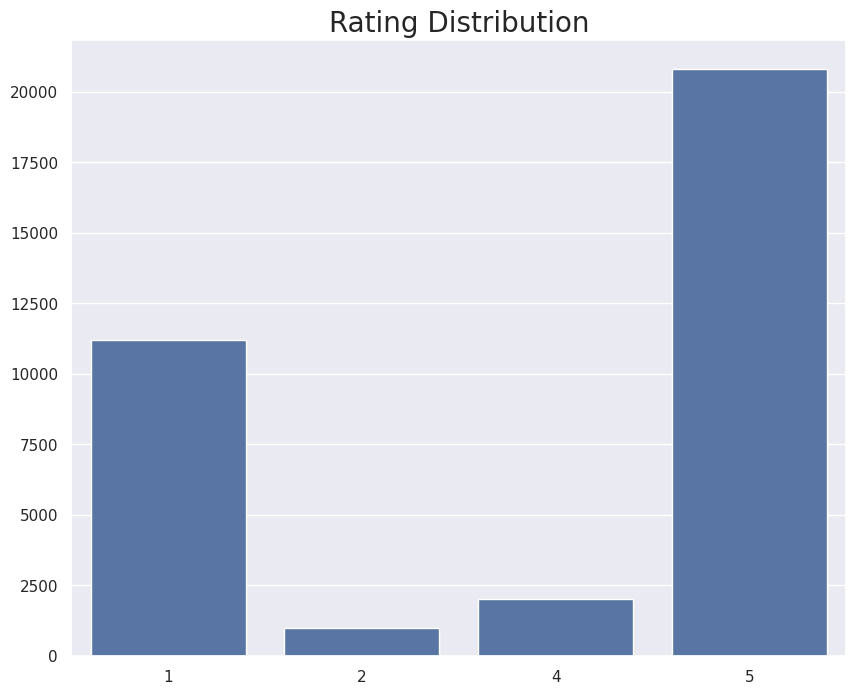

In [20]:
# View Train Rating Distribution
plt.figure(figsize=(10, 8))
plt.title('Rating Distribution', fontsize=20)

rating_distribution = X_train['Rating'].value_counts().sort_values()
sns.barplot(x=list(rating_distribution.keys()),
            y=rating_distribution.values)
display(rating_distribution.sort_values())

,count
Sentiment,
negative,12183
positive,22809


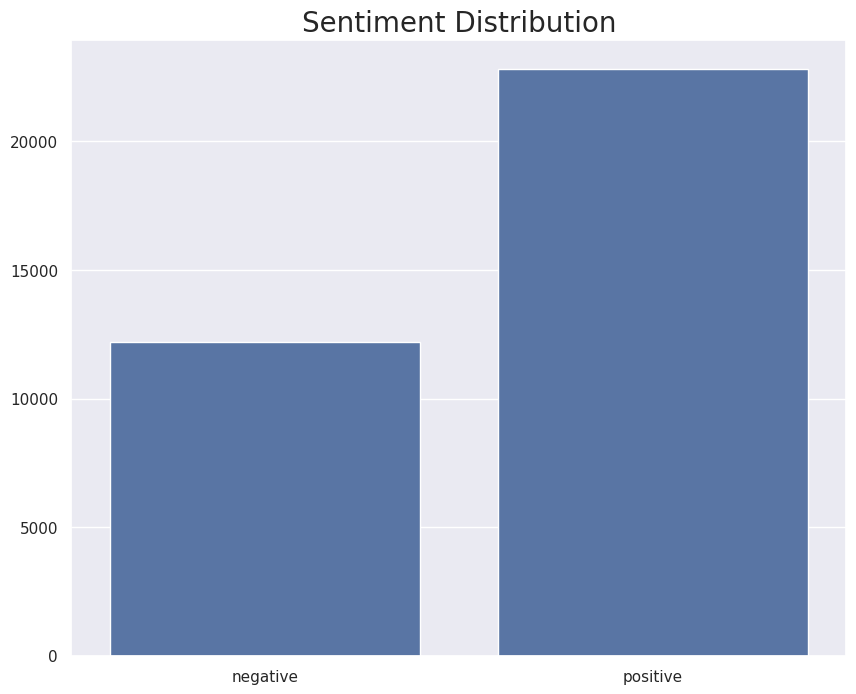

In [21]:
# View Sentiment Classification Distribution
plt.figure(figsize=(10, 8))
plt.title('Sentiment Distribution', fontsize=20)

sentiment_distribution = y_train.value_counts().sort_values()
sns.barplot(x=list(sentiment_distribution.keys()),
            y=sentiment_distribution.values)
display(sentiment_distribution.sort_values())

In [22]:
#Create a balanced dataset

# randomly draw 46000 examples from each class
df_balanced = pd.concat(
    [X_train, y_train],
    axis=1)


temp_positive = df_balanced[df_balanced.Sentiment == 'positive'].sample(
    n=12000,
    replace=False
)

temp_negative = df_balanced[df_balanced.Sentiment == 'negative'].sample(
    n=12000,
    replace=False
)

df_balanced = pd.concat(
    [temp_positive, temp_negative],
    axis=0)

# shuffle df_balanced
df_balanced = df_balanced.sample(frac=1) # frac=1 retains all the data
df_balanced.reset_index(drop=True, inplace=True) # reset index

print('After preprocessing, our data contains', df_balanced.shape[0], 'reviews.')

After preprocessing, our data contains 24000 reviews.


In [23]:
#Find average length of reviews for each sentiment classification
df_balanced['Review_Length'] = df_balanced['Review'].apply(lambda x: len(x.split()))
pos_review_length_avg = df_balanced[df_balanced['Sentiment']== 'positive']['Review_Length'].mean()
neg_review_length_avg = df_balanced[df_balanced['Sentiment']== 'negative']['Review_Length'].mean()
print('Average positive review length: ', pos_review_length_avg)
print('Average negative review length: ', neg_review_length_avg)

Average positive review length:  28.017583333333334
Average negative review length:  109.60616666666667


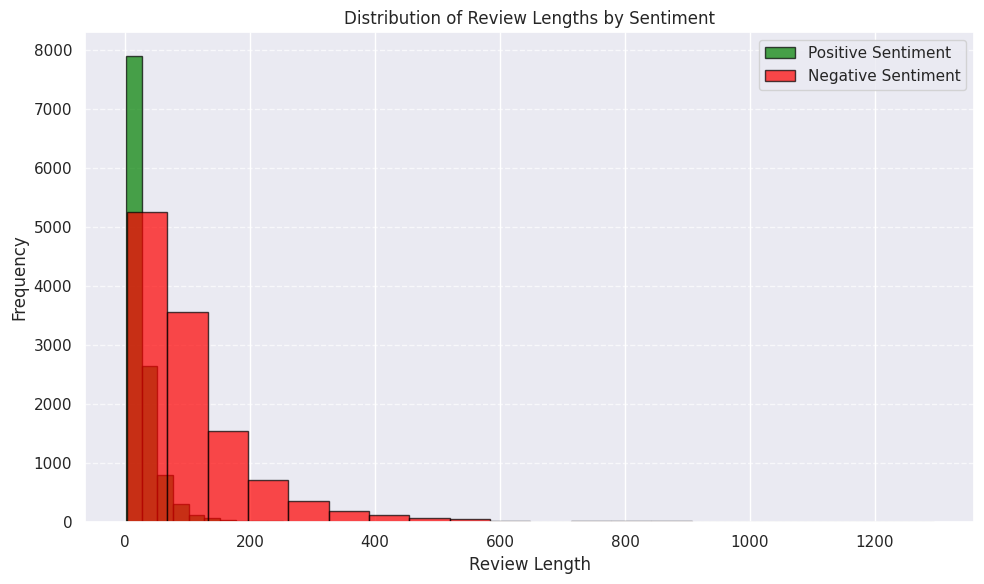

In [25]:
#Distribution of Review Length for Positive vs Negative Reviews
df_balanced['Distinct_Words'] = df_balanced['Review'].apply(lambda x:len(np.unique(x.lower().split())))

# Separate data based on sentiment
positive = df_balanced[df_balanced['Sentiment'] == 'positive']['Review_Length']
negative = df_balanced[df_balanced['Sentiment'] == 'negative']['Review_Length']

# Plot the distributions
plt.figure(figsize=(10, 6))
plt.hist(positive, bins=20, alpha=0.7, label='Positive Sentiment', color='green', edgecolor='black')
plt.hist(negative, bins=20, alpha=0.7, label='Negative Sentiment', color='red', edgecolor='black')

# Add plot details
plt.title('Distribution of Review Lengths by Sentiment')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

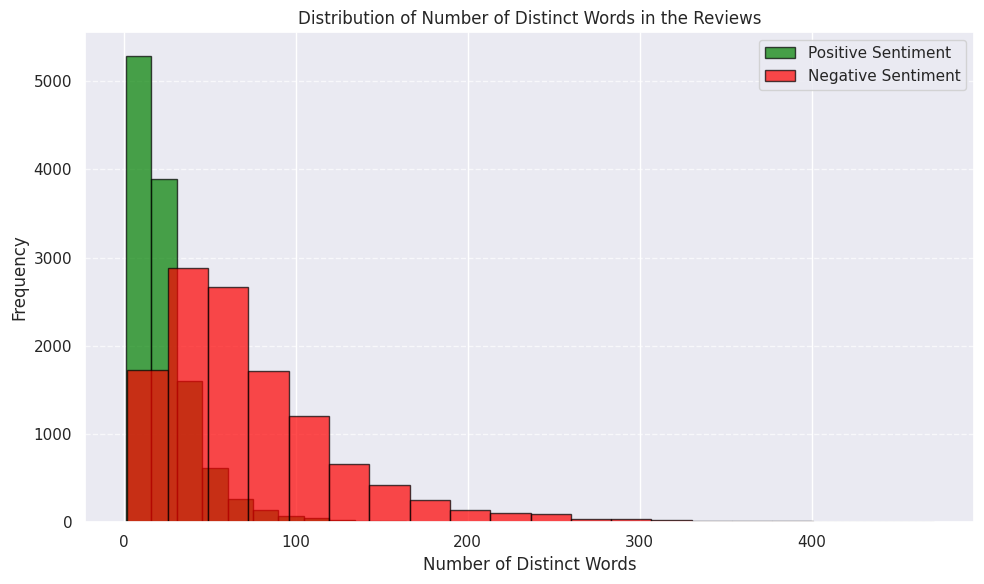

In [24]:
#Distribution of Distinct Words in a Review for Positive vs Negative Reviews
df_balanced['Distinct_Words'] = df_balanced['Review'].apply(lambda x:len(np.unique(x.lower().split())))

# Separate data based on sentiment
positive = df_balanced[df_balanced['Sentiment'] == 'positive']['Distinct_Words']
negative = df_balanced[df_balanced['Sentiment'] == 'negative']['Distinct_Words']

# Plot the distributions
plt.figure(figsize=(10, 6))
plt.hist(positive, bins=20, alpha=0.7, label='Positive Sentiment', color='green', edgecolor='black')
plt.hist(negative, bins=20, alpha=0.7, label='Negative Sentiment', color='red', edgecolor='black')

# Add plot details
plt.title('Distribution of Number of Distinct Words in the Reviews')
plt.xlabel('Number of Distinct Words')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [26]:
df_balanced

,Review,Rating,Sentiment,Review_Length,Distinct_Words
0,"They are bad company, charging £225.00 per mon...",1,negative,171,125
1,I ordered a new router from BT.(hub2). The eng...,1,negative,145,86
2,"It’s been great and more than satisfying, reco...",5,positive,23,21
3,Had broadband for a year all seemed fine\nHave...,1,negative,55,46
4,"Excellent communication, top notch product. Co...",5,positive,11,11
...,...,...,...,...,...
23995,Great price and product. Computer runs so much...,5,positive,10,10
23996,Absolutely terrible. Please don't even go into...,1,negative,109,80
23997,I used a voucher code from Unidays which I tho...,1,negative,276,159
23998,"Really good service, the Phone arrived very qu...",5,positive,18,18


In [27]:
#Transform categorical y variable to be binary, numerical format
# (0= negative, positive = 1)
X_train = df_balanced['Review']
y_train = df_balanced['Sentiment']
y_train = np.where(y_train.eq('positive'), 1, 0)

X_val = X_val['Review']
y_val = np.where(y_val.eq('positive'), 1, 0)

X_test = X_test['Review']
y_test = np.where(y_test.eq('positive'), 1, 0)

## Data Pre-Processing

In [28]:
# remove punctuation and other non-letter characters
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                           text)
    text = (re.sub('[\W]+', ' ', text.lower()) +
            ' '.join(emoticons).replace('-', ''))

    return text

X_train

,Review
0,"They are bad company, charging £225.00 per mon..."
1,I ordered a new router from BT.(hub2). The eng...
2,"It’s been great and more than satisfying, reco..."
3,Had broadband for a year all seemed fine\nHave...
4,"Excellent communication, top notch product. Co..."
...,...
23995,Great price and product. Computer runs so much...
23996,Absolutely terrible. Please don't even go into...
23997,I used a voucher code from Unidays which I tho...
23998,"Really good service, the Phone arrived very qu..."


In [29]:
#Apply data preprocessing to all input datasets
X_train = X_train.apply(preprocessor)
X_val = X_val.apply(str).apply(preprocessor)
X_test = X_test.apply(str).apply(preprocessor)


### Baseline Models

In [30]:
# Basline Model: SGD Classifier
pipe = Pipeline([
  ('vec', CountVectorizer(min_df=1000, preprocessor=preprocessor)),
  ('tfid', TfidfTransformer()),
  ('lr', SGDClassifier(loss='log_loss'))
])

# fit the model to the data
model = pipe.fit(X_train, y_train)

# predict sentiment on the test data frame
y_val_pred = model.predict(X_val)

# create the classification report
report = classification_report(y_val, y_val_pred)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      4081
           1       0.97      0.92      0.94      7583

    accuracy                           0.93     11664
   macro avg       0.91      0.93      0.92     11664
weighted avg       0.93      0.93      0.93     11664



In [31]:
#Baseline Model: Simple neural networks architecture

# Initialize the TF-IDF Vectorizer for data processing
vectorizer = TfidfVectorizer(max_features=1000)  # Limit to 1000 features for simplicity

# Fit and transform the reviews into numerical features
X_train_vec = vectorizer.fit_transform(np.array(X_train)).toarray()
X_val_vec = vectorizer.fit_transform(np.array(X_val)).toarray() # transform validation data
X_test_vec = vectorizer.fit_transform(np.array(X_test)).toarray() # transform test data


# Define a simple neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_vec.shape[1],)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model_history = model.fit(X_train_vec, np.array(y_train), epochs=5, batch_size=32,
          validation_data=(X_val_vec, np.array(y_val)))

# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_val_vec, np.array(y_val))
print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")


test_loss, test_accuracy = model.evaluate(X_test_vec, np.array(y_test))
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Epoch 1/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - accuracy: 0.8312 - loss: 0.3739 - val_accuracy: 0.7372 - val_loss: 0.6066
Epoch 2/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9455 - loss: 0.1471 - val_accuracy: 0.7438 - val_loss: 0.6537
Epoch 3/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9528 - loss: 0.1294 - val_accuracy: 0.7431 - val_loss: 0.6917
Epoch 4/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9569 - loss: 0.1213 - val_accuracy: 0.7425 - val_loss: 0.6748
Epoch 5/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9644 - loss: 0.1050 - val_accuracy: 0.7503 - val_loss: 0.6915
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7569 - loss: 0.6677
Val Loss: 0.6915, Val Accuracy: 0.7503
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7195 - loss: 0.7521
Test Loss: 0.7626, Test Accuracy: 0.7159


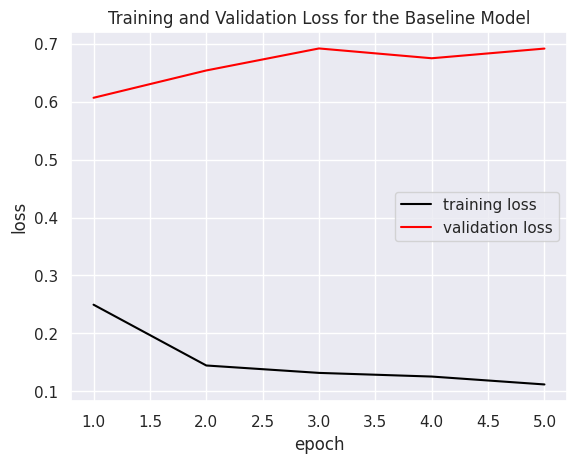

final train loss: 0.11191145
final train accuracy: 0.96058333
final val loss: 0.69151270
final val accuracy: 0.75034297


In [32]:
#Generate plot for loss values for the baseline model
# Plot the loss at each epoch and show final numbers.
# Plot training loss
plt.plot(range(1, len(model_history.history['loss']) + 1),
         model_history.history['loss'], color='black', label='training loss')

#Plot validation loss
plt.plot(range(1, len(model_history.history['val_loss']) + 1),
         model_history.history['val_loss'], color='red', label='validation loss')
plt.title("Training and Validation Loss for the Baseline Model")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

print('final train loss: %.8f' %model_history.history['loss'][-1])
print('final train accuracy: %.8f' %model_history.history['accuracy'][-1])

print('final val loss: %.8f' %model_history.history['val_loss'][-1])
print('final val accuracy: %.8f' %model_history.history['val_accuracy'][-1])

Model Improvements

LSTM Sequence-to-sequence modeling

In [40]:
# Model Improvement with Embedding + LSTM model
# Tokenize the text data
vocab_size = 1000  # Vocabulary size
oov_token = "<OOV>"  # Out-of-vocabulary token
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)

#create the vocabulary list based on reviews
tokenizer.fit_on_texts(np.array(X_train))

# Convert text to sequences
#sequences = tokenizer.texts_to_sequences(np.array(X_train))


# Convert text to numerical feature representation
X_train_sequences = tokenizer.texts_to_sequences(np.array(X_train))
X_val_sequences = tokenizer.texts_to_sequences(np.array(X_val))
X_test_sequences = tokenizer.texts_to_sequences(np.array(X_test))

# Pad sequences to make sure all reviews are the same input length
max_length = 400  # Maximum length of sequences
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding='post', truncating='post')
X_val_padded = pad_sequences(X_val_sequences, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length, padding='post', truncating='post')

tf.random.set_seed(1)


# Define LSTM neural network model with an embedding layer + Bidirectional LSTM
embedding_dim = 8  # Size of the embedding vectors


bi_lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=True, dropout=0.2)),  # LSTM layer for sequence modeling
    Bidirectional(LSTM(32, dropout=0.2)),
    Dense(32, activation='relu'),
    #Dropout(0.5),
    Dense(1, activation='sigmoid')  #binary classification
])


bi_lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


#Train the model
bi_lstm_model_history = bi_lstm_model.fit(np.array(X_train_padded), np.array(y_train), epochs=15, batch_size=32,callbacks=[EarlyStopping(monitor='loss',patience=3)],
          validation_data=(np.array(X_val_padded), np.array(y_val)))

Epoch 1/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 586s 767ms/step - accuracy: 0.7548 - loss: 0.4833 - val_accuracy: 0.9351 - val_loss: 0.1859
Epoch 2/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 651s 806ms/step - accuracy: 0.9338 - loss: 0.1817 - val_accuracy: 0.9228 - val_loss: 0.1833
Epoch 3/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 559s 746ms/step - accuracy: 0.9434 - loss: 0.1532 - val_accuracy: 0.9612 - val_loss: 0.1086
Epoch 4/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 561s 743ms/step - accuracy: 0.9558 - loss: 0.1275 - val_accuracy: 0.9597 - val_loss: 0.1110
Epoch 5/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 596s 789ms/step - accuracy: 0.9632 - loss: 0.1090 - val_accuracy: 0.9457 - val_loss: 0.1348
Epoch 6/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 597s 755ms/step - accuracy: 0.9599 - loss: 0.1130 - val_accuracy: 0.9623 - val_loss: 0.1119
Epoch 7/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 592s 789ms/step - accuracy: 0.9624 - loss: 0.1073 - val_accuracy: 0.9605 - val_loss: 0.1175
Epoch 8/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 588s 744ms/step - accuracy: 0.9657 -

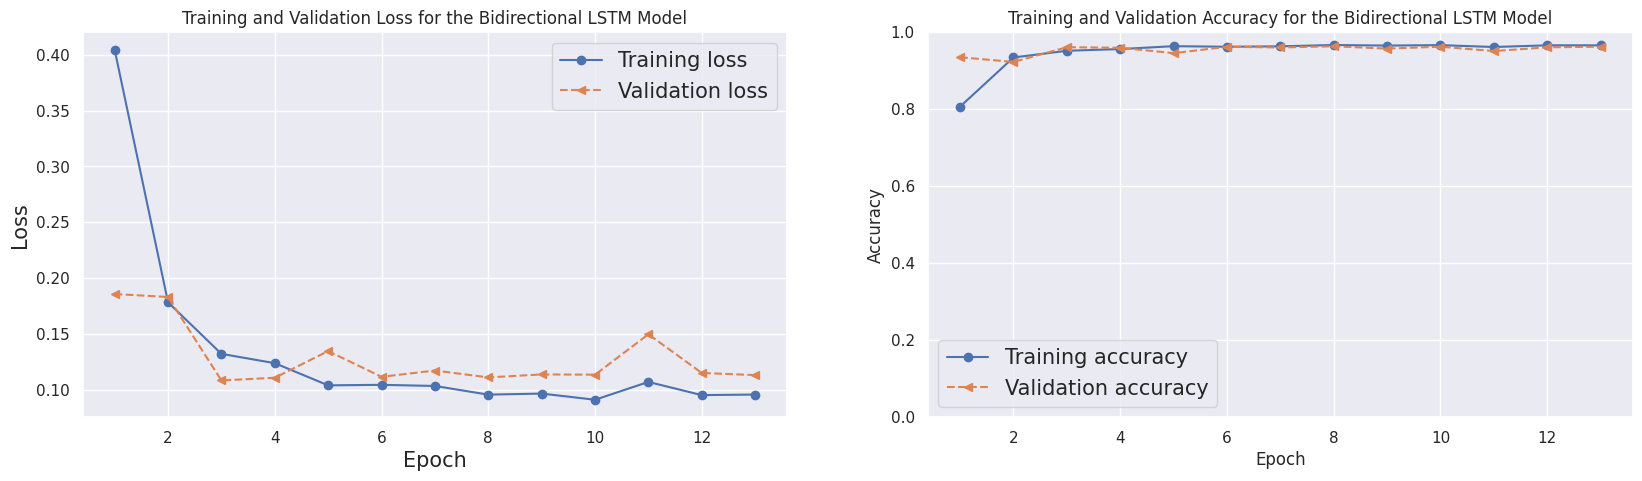

final train loss: 0.096
final train accuracy: 0.966
final val loss: 0.113
final val accuracy: 0.962


In [41]:
#hist = history.history
x_arr = np.arange(len(bi_lstm_model_history.history['loss'])) + 1

#Plot loss curves
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, bi_lstm_model_history.history['loss'], '-o', label='Training loss')
ax.plot(x_arr, bi_lstm_model_history.history['val_loss'], '--<', label='Validation loss')
ax.set_title("Training and Validation Loss for the Bidirectional LSTM Model")
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

#Plot accuracy curves
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, bi_lstm_model_history.history['accuracy'], '-o', label='Training accuracy')
ax.plot(x_arr, bi_lstm_model_history.history['val_accuracy'], '--<', label='Validation accuracy')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title("Training and Validation Accuracy for the Bidirectional LSTM Model")
ax.set_ylim(0,1)
plt.show()

print('final train loss: %.3f' %bi_lstm_model_history.history['loss'][-1])
print('final train accuracy: %.3f' %bi_lstm_model_history.history['accuracy'][-1])

print('final val loss: %.3f' %bi_lstm_model_history.history['val_loss'][-1])
print('final val accuracy: %.3f' %bi_lstm_model_history.history['val_accuracy'][-1])

In [42]:
bi_lstm_test_loss, bi_lstm_test_accuracy = bi_lstm_model.evaluate(X_test_padded, np.array(y_test))
print(f"Test Loss: {bi_lstm_test_loss:.4f}, Test Accuracy: {bi_lstm_test_accuracy:.4f}")

365/365 ━━━━━━━━━━━━━━━━━━━━ 62s 169ms/step - accuracy: 0.9620 - loss: 0.1085
Test Loss: 0.1094, Test Accuracy: 0.9612


CNN Modeling

In [42]:
#CNN with 3 convolutional layers
# Tokenize the text data
vocab_size = 1000  # Vocabulary size
oov_token = "<OOV>"  # Out-of-vocabulary token
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)

#create the vocabulary list based on reviews
tokenizer.fit_on_texts(np.array(X_train))

# Convert text to sequences
#sequences = tokenizer.texts_to_sequences(np.array(X_train))


# Convert text to numerical feature representation
X_train_sequences = tokenizer.texts_to_sequences(np.array(X_train))
X_val_sequences = tokenizer.texts_to_sequences(np.array(X_val))
X_test_sequences = tokenizer.texts_to_sequences(np.array(X_test))

# Pad sequences to make sure all reviews are the same input length
max_length = 400  # Maximum length of sequences
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding='post', truncating='post')
X_val_padded = pad_sequences(X_val_sequences, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length, padding='post', truncating='post')

tf.random.set_seed(1)

# Embed our training vocabulary into 10 dimensions.
# vocab_size_train = len(token_counts) + 2
embedding_dim = 10

# embedding_layer = tf.keras.layers.Embedding(
#     input_dim=vocab_size, output_dim=embedding_dim)

def build_model():
    ''''''
    # clear session and set a random seed for consistent behavior.
    tf.keras.backend.clear_session()
    tf.random.set_seed(1)

    # define model
    model = tf.keras.Sequential()

    ## add embedding layer ##
    #########################
    # (this is our imput layer)
    # embeddings will be learned during training
    # the weights for the embeddings are randomly initialized (just like any other layer!)
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=10,
        input_length=400, #limits length of sentence to 100 tokens
        name="embedding")
        ),

    ## first convolution ##
    #######################
    model.add(Conv1D(
        filters=128,
        kernel_size=4,
        padding='same',
        activation='relu'))

    # add dropout layer
    model.add(tf.keras.layers.Dropout(
        rate=0.5))

    # add maxpooling
    model.add(MaxPooling1D(pool_size=2))

    ## second convolution ##
    ########################
    model.add(Conv1D(
        filters=64,
        kernel_size=4,
        padding='same',
        activation='relu'))

    # add dropout layer
    model.add(tf.keras.layers.Dropout(
        rate=0.5))

    # add maxpooling
    model.add(MaxPooling1D(pool_size=2))

    ## third convolution ##
    #######################
    model.add(Conv1D(
        filters=32,
        kernel_size=5,
        padding='same',
        activation='relu'))

    # add dropout layer
    model.add(tf.keras.layers.Dropout(
        rate=0.5))

    # add maxpooling
    model.add(MaxPooling1D(pool_size=2))

    ## average embeddings ##
    ########################
    model.add(GlobalAveragePooling1D()),

    # add dropout layer
    model.add(tf.keras.layers.Dropout(
        rate=0.5))



    ## add final dense (output) layer ##
    ####################################
    model.add(Dense(1, activation='sigmoid'))

    # save embeddings before training
    #embeddings_untrained = model.get_layer('embedding').get_weights()[0]

    # print model summary
    model.summary()

    return model


model_cnn_2 = build_model()

model_cnn_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

tf.random.set_seed(1)
np.random.seed(1)
model_cnn_2_history = model_cnn_2.fit(
    np.array(X_train_padded), np.array(y_train), epochs=10,
          validation_data=(np.array(X_val_padded), np.array(y_val)))

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 99s 130ms/step - accuracy: 0.8139 - loss: 0.4430 - val_accuracy: 0.9175 - val_loss: 0.3926
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 160s 154ms/step - accuracy: 0.9214 - loss: 0.2314 - val_accuracy: 0.9444 - val_loss: 0.2462
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 125s 132ms/step - accuracy: 0.9489 - loss: 0.1566 - val_accuracy: 0.9571 - val_loss: 0.1770
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 138s 127ms/step - accuracy: 0.9552 - loss: 0.1393 - val_accuracy: 0.9564 - val_loss: 0.1682
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 138s 122ms/step - accuracy: 0.9626 - loss: 0.1184 - val_accuracy: 0.9571 - val_loss: 0.1553
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 92s 123ms/step - accuracy: 0.9636 - loss: 0.1126 - val_accuracy: 0.9504 - val_loss: 0.1733
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 88s 118ms/step - accuracy: 0.9639 - loss: 0.1120 - val_accuracy: 0.9583 - val_loss: 0.1456
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 144s 121ms/step - accuracy: 0.9658 - lo

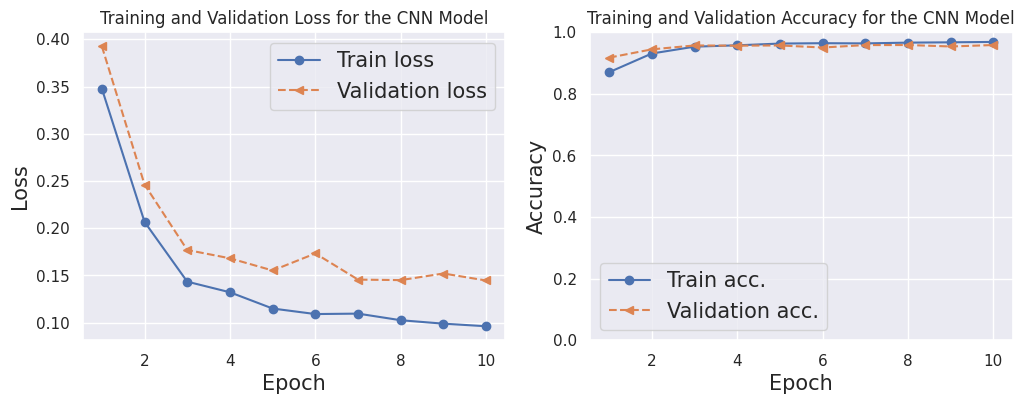

final train loss: 0.096
final train accuracy: 0.969
final val loss: 0.145
final val accuracy: 0.959


In [43]:
hist = model_cnn_2_history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.set_title("Training and Validation Loss for the CNN Model")

ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
ax.set_title("Training and Validation Accuracy for the CNN Model")
ax.set_ylim(0,1)
plt.show()

print('final train loss: %.3f' %model_cnn_2_history.history['loss'][-1])
print('final train accuracy: %.3f' %model_cnn_2_history.history['accuracy'][-1])

print('final val loss: %.3f' %model_cnn_2_history.history['val_loss'][-1])
print('final val accuracy: %.3f' %model_cnn_2_history.history['val_accuracy'][-1])

In [44]:
#CNN with 2 convolutional layers
# Tokenize the text data
vocab_size = 1000  # Vocabulary size
oov_token = "<OOV>"  # Out-of-vocabulary token
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)

#create the vocabulary list based on reviews
tokenizer.fit_on_texts(np.array(X_train))

# Convert text to sequences
#sequences = tokenizer.texts_to_sequences(np.array(X_train))


# Convert text to numerical feature representation
X_train_sequences = tokenizer.texts_to_sequences(np.array(X_train))
X_val_sequences = tokenizer.texts_to_sequences(np.array(X_val))
X_test_sequences = tokenizer.texts_to_sequences(np.array(X_test))

# Pad sequences to make sure all reviews are the same input length
max_length = 400  # Maximum length of sequences
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding='post', truncating='post')
X_val_padded = pad_sequences(X_val_sequences, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length, padding='post', truncating='post')

tf.random.set_seed(1)

# Embed our training vocabulary into 10 dimensions.
# vocab_size_train = len(token_counts) + 2
embedding_dim = 10

# embedding_layer = tf.keras.layers.Embedding(
#     input_dim=vocab_size, output_dim=embedding_dim)

def build_model():
    ''''''
    # clear session and set a random seed for consistent behavior.
    tf.keras.backend.clear_session()
    tf.random.set_seed(1)

    # define model
    model = tf.keras.Sequential()

    ## add embedding layer ##
    #########################
    # (this is our imput layer)
    # embeddings will be learned during training
    # the weights for the embeddings are randomly initialized (just like any other layer!)
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=10,
        input_length=400, #limits length of sentence to 100 tokens
        name="embedding")
        ),

    ## first convolution ##
    #######################
    model.add(Conv1D(
        filters=128,
        kernel_size=4,
        padding='same',
        activation='relu'))

    # add dropout layer
    model.add(tf.keras.layers.Dropout(
        rate=0.5))

    # add maxpooling
    model.add(MaxPooling1D(pool_size=2))

    ## second convolution ##
    ########################
    model.add(Conv1D(
        filters=64,
        kernel_size=4,
        padding='same',
        activation='relu'))

    # add dropout layer
    model.add(tf.keras.layers.Dropout(
        rate=0.5))

    # add maxpooling
    model.add(MaxPooling1D(pool_size=2))


    ## average embeddings ##
    ########################
    model.add(GlobalAveragePooling1D()),

    # add dropout layer
    model.add(tf.keras.layers.Dropout(
        rate=0.5))



    ## add final dense (output) layer ##
    ####################################
    model.add(Dense(1, activation='sigmoid'))

    # save embeddings before training
    #embeddings_untrained = model.get_layer('embedding').get_weights()[0]

    # print model summary
    model.summary()

    return model


model_cnn = build_model()

model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

np.random.seed(1)
model_cnn_history = model_cnn.fit(
    np.array(X_train_padded), np.array(y_train), epochs=10,
          validation_data=(np.array(X_val_padded), np.array(y_val)))

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 77s 100ms/step - accuracy: 0.8131 - loss: 0.4176 - val_accuracy: 0.9315 - val_loss: 0.3272
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 74s 99ms/step - accuracy: 0.9263 - loss: 0.2114 - val_accuracy: 0.9516 - val_loss: 0.2176
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 86s 105ms/step - accuracy: 0.9517 - loss: 0.1447 - val_accuracy: 0.9590 - val_loss: 0.1679
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 75s 100ms/step - accuracy: 0.9587 - loss: 0.1391 - val_accuracy: 0.9546 - val_loss: 0.2049
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 81s 99ms/step - accuracy: 0.9574 - loss: 0.1291 - val_accuracy: 0.9540 - val_loss: 0.1767
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 84s 102ms/step - accuracy: 0.9624 - loss: 0.1208 - val_accuracy: 0.9573 - val_loss: 0.1608
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 77s 103ms/step - accuracy: 0.9636 - loss: 0.1104 - val_accuracy: 0.9553 - val_loss: 0.1626
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 80s 100ms/step - accuracy: 0.9635 - loss: 0.1

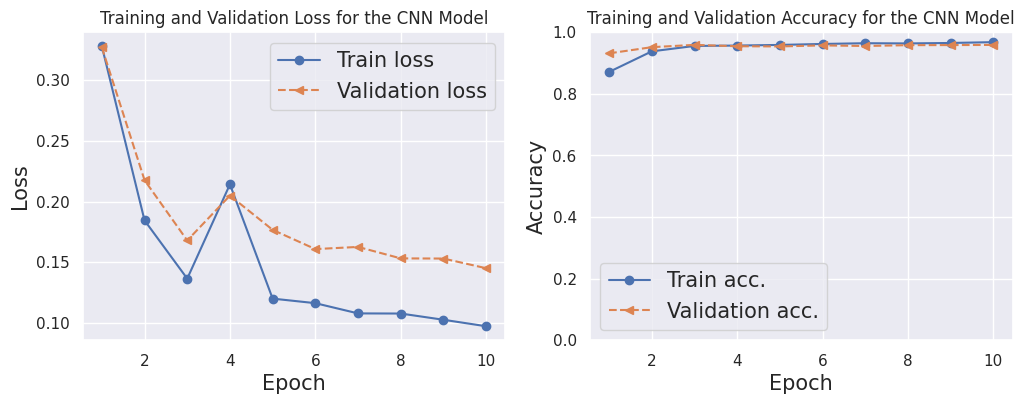

final train loss: 0.097
final train accuracy: 0.968
final val loss: 0.145
final val accuracy: 0.959


In [47]:
hist = model_cnn_history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.set_title("Training and Validation Loss for the CNN Model")

ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
ax.set_title("Training and Validation Accuracy for the CNN Model")
ax.set_ylim(0,1)
plt.show()

print('final train loss: %.3f' %model_cnn_history.history['loss'][-1])
print('final train accuracy: %.3f' %model_cnn_history.history['accuracy'][-1])

print('final val loss: %.3f' %model_cnn_history.history['val_loss'][-1])
print('final val accuracy: %.3f' %model_cnn_history.history['val_accuracy'][-1])

In [54]:
#Evaluate on test data
model_cnn_test_loss, model_cnn_test_accuracy = model_cnn.evaluate(X_test_padded, np.array(y_test))
print(f"Test Loss: {model_cnn_test_loss:.4f}, Test Accuracy: {model_cnn_test_accuracy:.4f}")

365/365 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.9637 - loss: 0.1255
Test Loss: 0.1278, Test Accuracy: 0.9609


Inspect the Learned Embeddings of the CNN Model

In [35]:
embeddings_cnn = model_cnn.get_layer('embedding').get_weights()[0]

In [36]:
# create an instance of the PCA class
pca = PCA(n_components=2) # PCA imported from sklearn.decomposition

# fit the data using the original X_train_std data; tranform X_train_std data
embeddings_trained_pca = pca.fit_transform(embeddings_cnn)

# visualize
display(pd.DataFrame(embeddings_trained_pca).head())

,0,1
0,-3.584246,1.746004
1,0.034146,-0.135384
2,-0.075733,0.051405
3,0.035941,0.056105
4,-0.105268,-0.007880


In [37]:
#np.array(tokenizer.word_index.keys())
count = 0
for k in tokenizer.word_index.keys():
  count += 1
  print(k)
  if count == 3:
    break


<OOV>
the
to


In [38]:
def plot_2d_embeddings(embeddings, id_start=1, count=100):
  # Get 1st and 2nd embedding dims for the desired tokens.
  x1 = embeddings[id_start:id_start+count, 0]
  x2 = embeddings[id_start:id_start+count, 1]

  # Get the corresponding words from the reverse index (for labeling).
  #tokens = [tokenizer.word_index.keys()[i] for i in range(id_start, id_start+count)]
  tokens = [k for k in tokenizer.word_index.keys()]

  # Plot with the plotly library.
  data = plotly.Scatter(x=x1, y=x2, text=tokens,
                        mode='markers', textposition='bottom left',
                        hoverinfo='text')
  fig = plotly.Figure(data=[data],
                      layout=plotly.Layout(title="Word Embeddings",
                                           hovermode='closest'))
  fig.show()

# Very frequent tokens tend to be more syntactic than semantic, so let's plot
# some rarer words.
plot_2d_embeddings(embeddings_cnn, id_start=1, count=500)